## Introduction

## Idea
The claim was that the directory structure would be very similar to each other over a period of time. We want to identify this time span by using a time-based analysis on the commits and their corresponding directory structures. We can use some advanced Git repo analysis for this task.

## Data creation script
Iterates over all commits and extracts basic information about the commit like sha, author and commit date (in `log.txt`) as well as the file's list of a specific version (in `files.txt`).

For each information set, it a new directory with the sha as unique identifier is created.

```bash
cd $1

sha_list=`git rev-list master`

for sha in $sha_list:
do
  data_dir="../data/$1/$sha"
  mkdir -p $data_dir
  git checkout $sha
  git log -n 1 $sha > $data_dir/log.txt
  git ls-files > $data_dir/files.txt
done
```

You can store this script e. g. into `extract.sh` and execute it for a repository with

```bash
sh execute.sh <path_git_repo>
```
and you'll get a directory / files structure like this
```
.
├── data
│   ├── lerna
│   │   ├── 001ec5882630cedd895f2c95a56a755617bb036c
│   │   │   ├── files.txt
│   │   │   └── log.txt
│   │   ├── 00242afa1efa43a98dc84815ac8f554ffa58d472
│   │   │   ├── files.txt
│   │   │   └── log.txt
│   │   ├── 007f20b89ae33721bd08f8bcdd0768923bcc6bc5
│   │   │   ├── files.txt
│   │   │   └── log.txt
```

The content is as follows:

**`files.txt`**
```
.babelrc
.editorconfig
.eslintrc.yaml
.github/ISSUE_TEMPLATE.md
.github/PULL_REQUEST_TEMPLATE.md
.gitignore
.npmignore
.travis.yml
CHANGELOG.md
CODE_OF_CONDUCT.md
CONTRIBUTING.md
FAQ.md
LICENSE
README.md
appveyor.yml
bin/lerna.js
doc/hoist.md
doc/troubleshooting.md
lerna.json
package.json
src/ChildProcessUtilities.js
src/Command.js
src/ConventionalCommitUtilities.js
src/FileSystemUtilities.js
src/GitUtilities.js
src/NpmUtilities.js
...
```

**`log.txt`**
```
commit 001ec5882630cedd895f2c95a56a755617bb036c
Author: Daniel Stockman <daniels@zillowgroup.com>
Date:   Thu Aug 10 09:56:14 2017 -0700

    chore: fs-extra 4.x
```

With this data, we have the base for analysing a probably similar directure structure layout over time.

```
abd83718682d7496426bb35f2f9ca20f10c2468d,2015-12-04 23:29:27 +1100
.gitignore
LICENSE
README.md
bin/lerna.js
lib/commands/bootstrap.js
lib/commands/index.js
lib/commands/publish.js
lib/init.js
lib/progress-bar.js
package.json
```

## Load all files with the files listings
I've executed the script for lerna as well as the web-build-tools. First, we first get all the `files.txt` using `glob`.

In [79]:
import glob

file_list = glob.glob(r'C:/dev/forensic/data/**/*.txt', recursive=True)
file_list = [x.replace("\\", "/") for x in file_list]
file_list[:5]

['C:/dev/forensic/data/lerna/001ec5882630cedd895f2c95a56a755617bb036c.txt',
 'C:/dev/forensic/data/lerna/00242afa1efa43a98dc84815ac8f554ffa58d472.txt',
 'C:/dev/forensic/data/lerna/007f20b89ae33721bd08f8bcdd0768923bcc6bc5.txt',
 'C:/dev/forensic/data/lerna/0083f33f50f69069245325e25c5b9d08445860b0.txt',
 'C:/dev/forensic/data/lerna/00b979f45b6c3886380f6dad01473e2e2ff88db0.txt']

We can then import the data by looping through all the files and read in the corresponding files' content. We further extract the information items we need on the fly from the path as well as the content of `log.txt`. The result is stored into a Pandas DataFrame for further analysis.

In [80]:
import pandas as pd

dfs = []

for files_file in file_list:
    
    try:
        files_df = pd.read_csv(files_file, names=['sha', 'timestamp'])
        files_df['project'] = files_file.split("/")[-2]
        files_df['file'] = files_df.sha
        files_df['sha'] = files_df.sha[0]
        files_df['timestamp'] = pd.to_datetime(files_df.timestamp[0])
        files_df = files_df[1:]
        files_df
        dfs.append(files_df)
    except OSError as e:
        print((e,files_file))
    
file_log = pd.concat(dfs, ignore_index=True)
file_log.head()

(OSError('Initializing from file failed',), 'C:/dev/forensic/data/lerna/e9b2ac3c5ee815af933f997b867035f6b7ac24ae\uf03a.txt')
(OSError('Initializing from file failed',), 'C:/dev/forensic/data/web-build-tools/2fd33432c0ff0e951cfaca91425c513e4ce394ab\uf03a.txt')


,sha,timestamp,project,file
0,001ec5882630cedd895f2c95a56a755617bb036c,2017-08-10 16:56:14,lerna,.babelrc
1,001ec5882630cedd895f2c95a56a755617bb036c,2017-08-10 16:56:14,lerna,.editorconfig
2,001ec5882630cedd895f2c95a56a755617bb036c,2017-08-10 16:56:14,lerna,.eslintrc.yaml
3,001ec5882630cedd895f2c95a56a755617bb036c,2017-08-10 16:56:14,lerna,.github/ISSUE_TEMPLATE.md
4,001ec5882630cedd895f2c95a56a755617bb036c,2017-08-10 16:56:14,lerna,.github/PULL_REQUEST_TEMPLATE.md


In [81]:
file_log.file = pd.Categorical(file_log.file)
file_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2241204 entries, 0 to 2241203
Data columns (total 4 columns):
sha          object
timestamp    datetime64[ns]
project      object
file         category
dtypes: category(1), datetime64[ns](1), object(2)
memory usage: 55.8+ MB


In [141]:
dir_log = dir_log[
    (dir_log.project=='lerna') & (dir_log.file.str.endswith(".js")) |
    (dir_log.project=='web-build-tools') & (dir_log.file.str.endswith(".ts"))
]
dir_log.project.value_counts()

web-build-tools    825298
lerna              107734
Name: project, dtype: int64

In [145]:
dir_log = dir_log[dir_log.file.str.contains("/")].copy()
dir_log['last_dir'] = dir_log.file.str.split("/").str[-2]
dir_log['last_dir_id'] = pd.factorize(dir_log.last_dir)[0]
dir_log.head()

,sha,timestamp,project,file,last_dir,last_dir_id,date
15,001ec5882630cedd895f2c95a56a755617bb036c,2017-08-10 16:56:14,lerna,bin/lerna.js,bin,0,2017-08-10
20,001ec5882630cedd895f2c95a56a755617bb036c,2017-08-10 16:56:14,lerna,src/ChildProcessUtilities.js,src,1,2017-08-10
21,001ec5882630cedd895f2c95a56a755617bb036c,2017-08-10 16:56:14,lerna,src/Command.js,src,1,2017-08-10
22,001ec5882630cedd895f2c95a56a755617bb036c,2017-08-10 16:56:14,lerna,src/ConventionalCommitUtilities.js,src,1,2017-08-10
23,001ec5882630cedd895f2c95a56a755617bb036c,2017-08-10 16:56:14,lerna,src/FileSystemUtilities.js,src,1,2017-08-10


In [143]:
dir_log['date'] = dir_log.timestamp.dt.date
dir_log.head()

,sha,timestamp,project,file,last_dir,last_dir_id,date
15,001ec5882630cedd895f2c95a56a755617bb036c,2017-08-10 16:56:14,lerna,bin/lerna.js,bin,0,2017-08-10
20,001ec5882630cedd895f2c95a56a755617bb036c,2017-08-10 16:56:14,lerna,src/ChildProcessUtilities.js,src,1,2017-08-10
21,001ec5882630cedd895f2c95a56a755617bb036c,2017-08-10 16:56:14,lerna,src/Command.js,src,1,2017-08-10
22,001ec5882630cedd895f2c95a56a755617bb036c,2017-08-10 16:56:14,lerna,src/ConventionalCommitUtilities.js,src,1,2017-08-10
23,001ec5882630cedd895f2c95a56a755617bb036c,2017-08-10 16:56:14,lerna,src/FileSystemUtilities.js,src,1,2017-08-10


In [133]:
grouped = dir_log.groupby(['project', pd.Grouper(level='date', freq="D"),'last_dir_id'])[['sha']].last()
grouped.head()

ValueError: The level date is not valid

In [121]:
grouped['existent'] = 1
grouped.head()

sha  existent
project date       last_dir_id               
lerna   2015-12-04 1              1         1
                   4              1         1
                   77             1         1
        2015-12-06 1              1         1
                   4              1         1

In [129]:
test = grouped.pivot_table('existent', ['project', 'date'], 'last_dir_id').fillna(0)
test.head()

AttributeError: 'DataFrame' object has no attribute 'date'

In [127]:
lerna = test.loc['lerna'][0]
lerna

date
2015-12-04    0.0
2015-12-06    0.0
2015-12-08    0.0
2015-12-14    0.0
2015-12-21    0.0
2015-12-22    0.0
2015-12-24    0.0
2015-12-29    0.0
2016-01-07    0.0
2016-01-17    0.0
2016-01-20    0.0
2016-01-22    0.0
2016-01-23    0.0
2016-01-25    0.0
2016-01-26    0.0
2016-01-27    0.0
2016-01-28    0.0
2016-01-29    0.0
2016-01-30    0.0
2016-02-01    0.0
2016-02-02    0.0
2016-02-08    0.0
2016-02-11    0.0
2016-02-12    0.0
2016-02-13    0.0
2016-02-16    0.0
2016-02-20    0.0
2016-02-22    0.0
2016-02-23    0.0
2016-02-24    0.0
             ... 
2018-03-28    1.0
2018-03-29    1.0
2018-03-30    1.0
2018-03-31    1.0
2018-04-01    1.0
2018-04-02    1.0
2018-04-03    1.0
2018-04-06    1.0
2018-04-09    1.0
2018-04-10    1.0
2018-04-11    1.0
2018-04-13    1.0
2018-04-16    1.0
2018-04-17    1.0
2018-04-18    1.0
2018-04-23    1.0
2018-04-24    1.0
2018-04-26    1.0
2018-04-27    1.0
2018-05-01    1.0
2018-05-03    1.0
2018-05-07    1.0
2018-05-08    1.0
2018-05-09    1.0
2018-

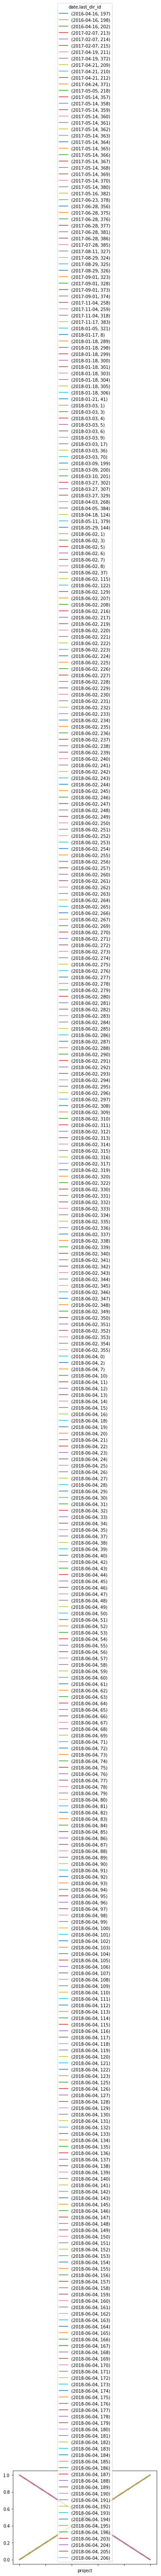

In [105]:
%maplotlib inline 
test.plot()

In [83]:
timed_log = dir_log.set_index(['timestamp', 'project'])
timed_log.head()

sha  \
timestamp           project                                             
2017-08-10 16:56:14 lerna    001ec5882630cedd895f2c95a56a755617bb036c   
                    lerna    001ec5882630cedd895f2c95a56a755617bb036c   
                    lerna    001ec5882630cedd895f2c95a56a755617bb036c   
                    lerna    001ec5882630cedd895f2c95a56a755617bb036c   
                    lerna    001ec5882630cedd895f2c95a56a755617bb036c   

                                                         file last_dir  \
timestamp           project                                              
2017-08-10 16:56:14 lerna           .github/ISSUE_TEMPLATE.md  .github   
                    lerna    .github/PULL_REQUEST_TEMPLATE.md  .github   
                    lerna                        bin/lerna.js      bin   
                    lerna                        doc/hoist.md      doc   
                    lerna              doc/troubleshooting.md      doc   

                             last_dir_id  
timestamp           project               
2017-08-10 16:56:14 lerna              0  
                    lerna              0  
                    lerna              1  
                    lerna              2  
                    lerna              2

In [84]:
timed_log.resample("W").first()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'MultiIndex'

In [ ]:
%matplotlib inline
timed.\
pivot_table('last_dir_id', timed.index, 'project')\
.fillna(method='ffill').dropna().plot()

For each file, we have now a row the complete commit information available for both repositories.

In [ ]:
file_log[file_log.project == "lerna"].iloc[0]

In [ ]:
file_log[file_log.project == "web-build-tools"].iloc[0]

## Basic statistics

Let's take a look at our read-in data.

In [ ]:
file_log.info()

These are the number of entries for each repository.

In [ ]:
file_log.project.value_counts()

The amount of commits for each repository are.

In [ ]:
file_log.groupby('project').sha.nunique()

## Data preparation

We need to adopt the data to the domain analyzed. We want to create a similarity measure between the directory structure of the lerna repository and the rush componente of the web-build-tools repository. The later is a little bit tricky, because there is a shift in the directory renaming. 

In [ ]:
file_log[file_log.project=="web-build-tools"].iloc[0]

In [ ]:
file_log[file_log.project=="web-build-tools"].file.iloc[-10:]

In [ ]:
lerna = file_log[file_log.project == "lerna"]
lerna.info()

In [ ]:
rush = file_log[file_log.project == "web-build-tools"]
rush.info()

In [ ]:
from scipy.spatial.distance import hamming

def calculate_hamming(row):
    lerna = row.file_list_lerna.split("\n")
    lerna = [x.rsplit(".", maxsplit=1)[0] for x in lerna]
    rush = row.file_list_rush.split("\n")
    rush = [x.rsplit(".", maxsplit=1)[0] for x in rush]
    count = 0
    for i in lerna:
        if i in rush:
            count = count + 1
    return count
    
comp["amount"] = comp.apply(calculate_hamming, axis=1)
comp.head()

In [ ]:
%matplotlib inline
comp.amount.plot()

In [ ]:
comp.resample("W").amount.mean().plot()

In [ ]:
comp[comp.amount == comp.amount.max()]